In [1]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import argparse, sys, os, errno
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
import seaborn as sns
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from unet_128_model_row_column import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
%pylab inline
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
set_session(tf.Session(config=config))
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# mutation map
bash
bin/preprocess.py GenerateMutatedSequences \
    -i data/Known/fasta/5s_Bacillus-licheniformis-2.fa \
    -o tmp/5s_Bacillus-licheniformis-2.mutate_and_map.fa
### 先运行第一个生成突变fasta的
### 然后输入到第二个里  
bin/deepfold2.py PredictDeepfold1D \
    -i tmp/5s_Bacillus-licheniformis-2.mutate_and_map.fa --format fasta \
    --model-file 'trained_models/icSHAPE/Spitale_2015_invivo/r=CDS,p=5,w=100,m=resnet1_dense' \
    --swap-labels \
    --dense-pred-file tmp/5s_Bacillus-licheniformis-2.mutate_and_map.dense_predictions.h5
简单的思路：先小范围尝试 <br>
找一些片段 每个位点（需要icshape非nan吗）突变成其他三个，画图看二维和一维的预测值是否变化 <br>
即每次突变一个位点，一个序列可以突变256个位点，每个位点三种变化，然后找20个  256*3*20 <br>
只绘图吗？能否定量分析？  不同碱基有关系吗？只看长程关系就好？   分析一下长程出现的变化的比例
1 用bash脚本处理**之前用的相同**的fasta
2 用之前的产生图片的方法产生新的图像,找第一条的fasta的序列试试产生一张图 确认和之前的未突变的可以对应上
3 用预存的model预测新的结果  画图  
画绝对变化图？再滤掉噪音？
第一步结果  一个fasta文件  每个位点突变三种的序列 <br>
取前256*3条，切出来其前256个
对每个array实施突变 <br>
ATCG的顺序编码  产生762个矩阵  依顺序分别把每行改成另外三种形式
思路这样：model已经训练好了，然后从Spitale_2015_invivo_CDS_0.1选第一条出来，转成图，算一个icSHAPE
然后再突变，算icSHAPE

In [3]:
def prepare_data(numbers):
    '''
        use different seqs
    '''
    seqs = {}
    with h5py.File('data/new/Spitale_2015_invivo_CDS_0.1') as f:
        for i in range(numbers):
            seqs[i] = f['X_train'][128*i]
    return seqs
def convert_to_image(x):
    m = (np.repeat(x, 4, axis=1)[np.newaxis, :, :]*np.tile(x, 4)[:, np.newaxis, :])
    return m
def Model():
    #为转成十六通道的图片预测shape做准备
    model = UNET_128()
    optim = Adam()
    model.compile(optimizer=optim, loss=CrossEntropyLoss(model,10), metrics=[binary_accuracy_with_nan,binary_crossentropy_with_nan,MSE(model)])
    loss=CrossEntropyLoss(model,10)
    model = load_model('output/newunet_row_col_mse_1.30_3.hdf5',custom_objects = {"CrossEntropyLoss": loss,\
                                                                            'binary_accuracy_with_nan':binary_accuracy_with_nan,\
                                                                            'binary_crossentropy_with_nan':binary_crossentropy_with_nan,\
                                                                            'MSE':MSE(model)})
    return model
def generate_mutation_map(seq):
    '''seq shape: 128*4
    将一条序列每个位点突变
    return 384*128*4
    '''
    length = 128
    #需要生成的 1的位置
    mutated = np.ndarray([length*3,length,4]).astype('int')
    for j in range(length):
        position = np.setdiff1d(np.array([0,1,2,3]),np.where(seq[j]==1)[0][0])
        for i in range(3):
            a = np.zeros(4).astype('int')
            array = np.copy(seq)
            a[position[i]] = 1
            array[j] = a
            mutated[j*3+i] = array
    images_mutated = np.ndarray([length*3,length,length,16]).astype('int')
    for i in range(length*3):
        images_mutated[i] = convert_to_image(mutated[i])
    images_origin = convert_to_image(seq)
    model = Model()
    predict_origin = model.predict(images_origin.reshape(1,128,128,16))[0][:128]
    predict_mutated = model.predict(images_mutated)[:,:128]
    mutation_map = np.ndarray([128*3,128])
    for i in range(128*3):
        mutation_map[i] =  predict_origin - predict_mutated[i]
    return mutation_map
def mutiple_mutation_maps(seqs,numbers):
    '''
        output many seqs mutation maps
    '''
    mutation_map = {}
    for i in tqdm(range(numbers)):
        mutation_map[i] = generate_mutation_map(seqs[i])
    mutation_map_ = np.array([val for (key,val) in mutation_map.iteritems()],dtype)
    mutation_map_ = mutation_map_.astype('float')
    return mutation_map_
def convert_to_cube(map):
    cube_map = np.ndarray([384,384])
    for i in range(128):
        cube_map[:,3*i] = map[:,i]
        cube_map[:,3*i+1] = map[:,i]
        cube_map[:,3*i+2] = map[:,i]
    return cube_map
def multi_cube_map(mutation_map,numbers):
    '''generate different seqs' cube array '''
    cube_map = {}
    for i in range(numbers):
        cube_map[i] = convert_to_cube(mutation_map[i])
    return cube_map

In [4]:
seqs = prepare_data(16)

In [5]:
mut_maps = mutiple_mutation_maps(seqs,16)

 94%|█████████▍| 15/16 [07:50<00:43, 43.26s/it]

ResourceExhaustedError: OOM when allocating tensor with shape[32,16,128,128]
	 [[Node: conv2d_1_16/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_input_1_16_0_1/_42681, conv2d_1_16/kernel/read)]]
	 [[Node: concatenate_6_16/concat/_42751 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2381_concatenate_6_16/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'conv2d_1_16/convolution', defined at:
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-7ba4422be0e8>", line 1, in <module>
    mut_maps = mutiple_mutation_maps(seqs,16)
  File "<ipython-input-3-9fc56055c645>", line 54, in mutiple_mutation_maps
    mutation_map[i] = generate_mutation_map(seqs[i])
  File "<ipython-input-3-9fc56055c645>", line 41, in generate_mutation_map
    model = Model()
  File "<ipython-input-3-9fc56055c645>", line 19, in Model
    model = load_model('output/newunet_row_col_mse_1.30_3.hdf5',custom_objects = {"CrossEntropyLoss": loss,                                                                            'binary_accuracy_with_nan':binary_accuracy_with_nan,                                                                            'binary_crossentropy_with_nan':binary_crossentropy_with_nan,                                                                            'MSE':MSE(model)})
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/models.py", line 240, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/models.py", line 314, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/utils/generic_utils.py", line 140, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 2500, in from_config
    process_node(layer, node_data)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 2457, in process_node
    layer(input_tensors[0], **kwargs)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3195, in conv2d
    data_format=tf_data_format)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 670, in convolution
    op=op)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 662, in op
    name=name)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,16,128,128]
	 [[Node: conv2d_1_16/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_input_1_16_0_1/_42681, conv2d_1_16/kernel/read)]]
	 [[Node: concatenate_6_16/concat/_42751 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2381_concatenate_6_16/concat", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
cube_map = multi_cube_map(mut_maps,16)

RdBu  重复列    
对齐补0  画图
对齐  按列求和  平均分布  按照位置画！
对齐  128个boxplot
需要绝对值 normalize等等吗
数值计算的指标！
倒数第二层输出！
看每行五个碱基之外的变化的hist
怎么会有全是红的？

In [ ]:
fig, ax = plt.subplots(8,2, figsize=(20,80))
for i in range(8):
    for j in range(2):
        ax[i,j].matshow(cube_map[2*i+j],cmap='RdBu_r', interpolation='none')
    #fig.savefig('mutation/mutate_and_map_heatmap_'+str(t)+'.png')

画boxplot 能追溯到位置信息！
对齐到中央  旁边补零  然后 画boxplot
384*128 ->384*256

In [41]:
def generate_boxplot(mutationmap):
    new_map = np.ndarray([384,256])
    for i in range(128):
        new_map[3*i] = np.concatenate((np.concatenate((np.zeros(128-i),mutationmap[3*i])),np.zeros(i)))
        new_map[3*i+1] = np.concatenate((np.concatenate((np.zeros(128-i),mutationmap[3*i+1])),np.zeros(i)))
        new_map[3*i+2] = np.concatenate((np.concatenate((np.zeros(128-i),mutationmap[3*i+2])),np.zeros(i)))
    return new_map
def generate_mutiple_boxplot(mutationmaps,numbers):
    '''
        numbers: 序列数 map数
        mutationmaps:number个数个mutation map在一起
    '''
    new_map = np.ndarray([numbers,384,256])
    for i in range(numbers):
        new_map[i] = generate_boxplot(mutationmaps[i])
    return new_map

In [6]:
#中央对齐的
#matshow(generate_boxplot(mutation_map_[0]),cmap=cm.RdBu_r)

In [84]:
boxplot = {}
for i in tqdm(range(100)):
    boxplot[i] = generate_boxplot(mutation_map_[i])
boxplot = np.array([val for (key,val) in boxplot.iteritems()],dtype)
boxplot = boxplot.astype('float')
with h5py.File('mutation/boxplot_100') as f:
    f.create_dataset('box',data = boxplot)

100%|██████████| 100/100 [00:00<00:00, 428.47it/s]


In [90]:
boxplot[0].shape

(384, 256)

In [9]:
with h5py.File('mutation/boxplot_100') as f:
    boxplot = f['box'][:]

256个box

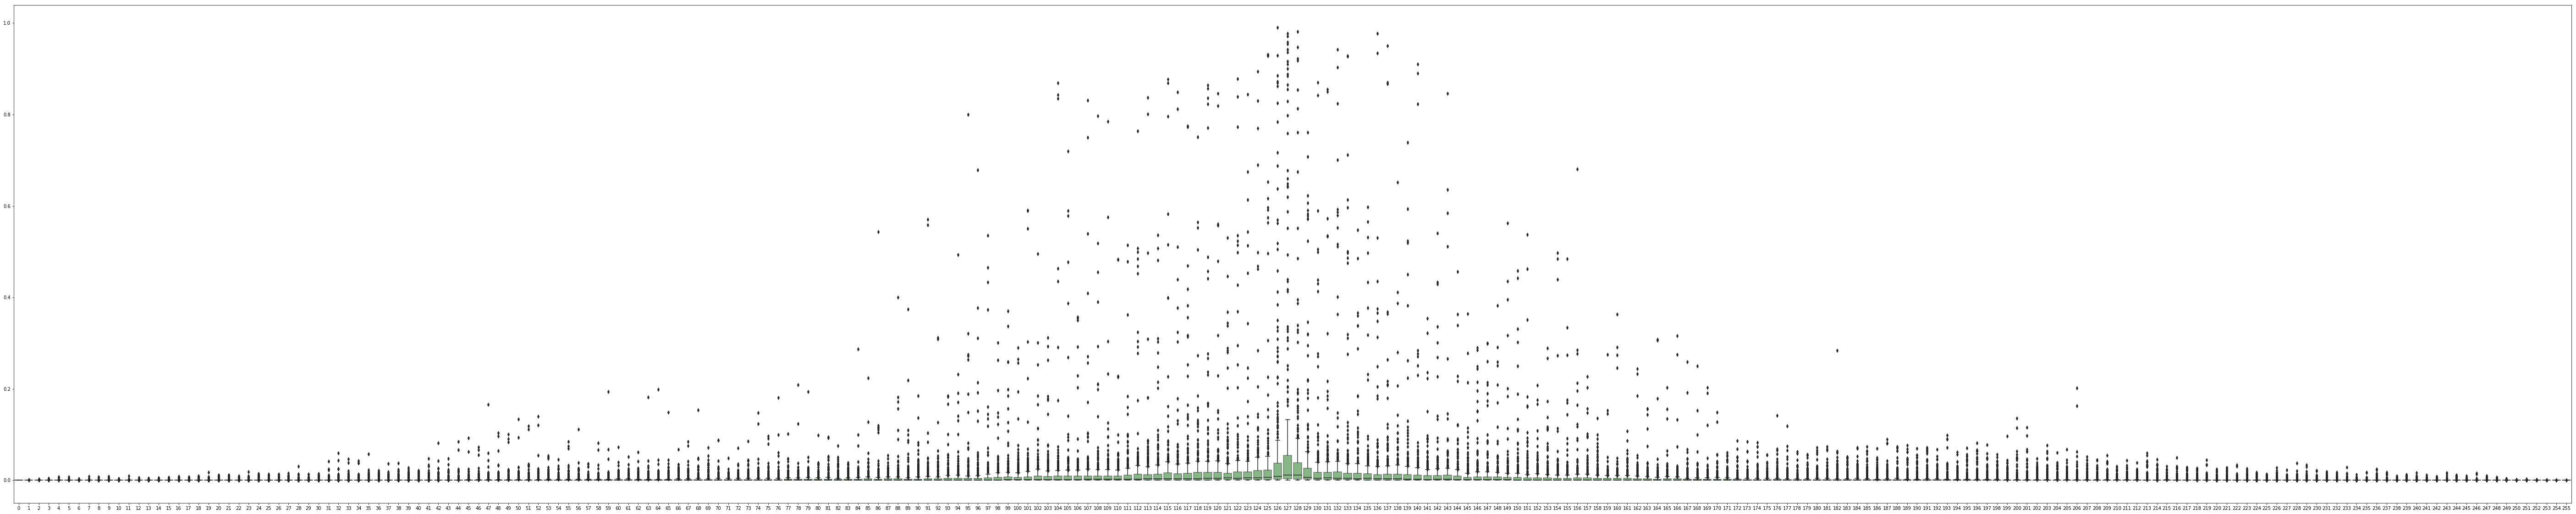

In [94]:
fig, ax = subplots(figsize=(100,20))
sns.boxplot(data = pd.DataFrame(data=np.abs(boxplot[0])), ax=ax,boxprops=dict(alpha=.5),color='g')
fig.savefig('mutation/boxplot/boxplot.png')

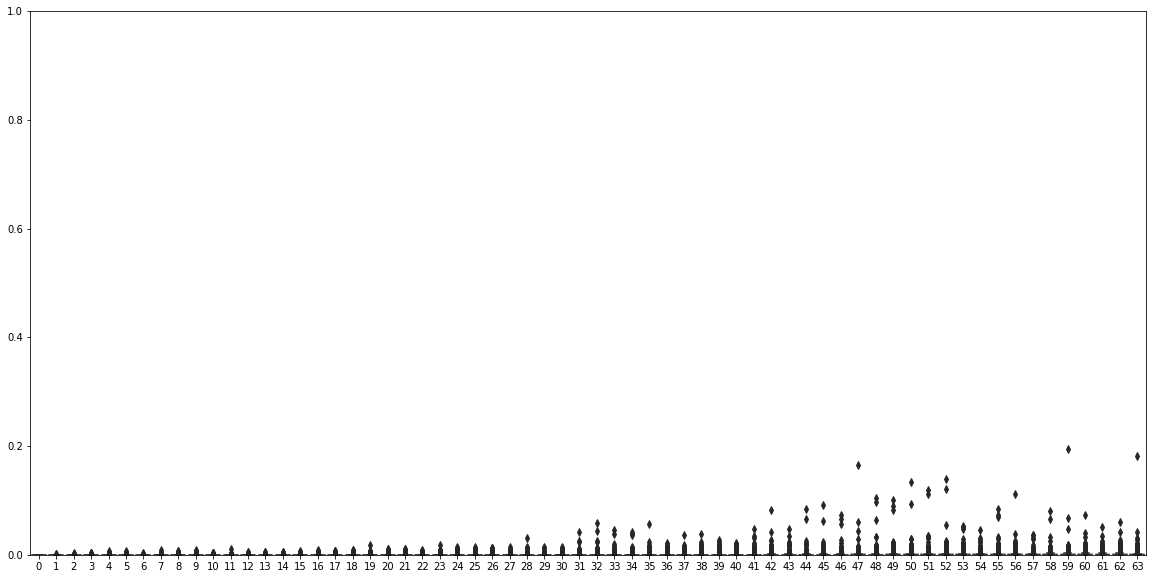

In [43]:
fig, ax = subplots(figsize=(20, 10))
sns.boxplot(data = pd.DataFrame(data=np.abs(boxplot[0])).iloc[:,:64], ax=ax,boxprops=dict(alpha=.5),color='g')
ax.set(ylim=(0, 1.0))
fig.savefig('mutation/boxplot_1.png')

fig, ax = subplots(figsize=(20, 10))
sns.boxplot(data = pd.DataFrame(data=np.abs(boxplot[0])).iloc[:,64:128], ax=ax,boxprops=dict(alpha=.5),color='g')
ax.set(ylim=(0, 1.0))
fig.savefig('mutation/boxplot_2.png')

fig, ax = subplots(figsize=(20, 10))
sns.boxplot(data = pd.DataFrame(data=np.abs(boxplot[0])).iloc[:,128:128+64:], ax=ax,boxprops=dict(alpha=.5),color='g')
ax.set(ylim=(0, 1.0))
fig.savefig('mutation/boxplot_3.png')

fig, ax = subplots(figsize=(20, 10))
sns.boxplot(data = pd.DataFrame(data=np.abs(boxplot[0])).iloc[:,128+64:], ax=ax,boxprops=dict(alpha=.5),color='g')
fig.savefig('mutation/boxplot_4.png')

可以分开画图 拼到一起
或者画中位数 25  75的折线

In [5]:
with h5py.File('mutation/boxplot_100') as f:
    boxplot = f['box'][:]

In [110]:
def plot_percentile(boxplotarray,inter):
    boxplotarray = np.abs(boxplotarray)
    per = {}
    fig, ax = subplots(figsize=(12, 8))
    for i in range(100/inter):
        per[i] = np.percentile(boxplotarray,i*inter,axis =0)
        ax.plot(per[i])
    return per

In [114]:
a[0].shape

(256,)

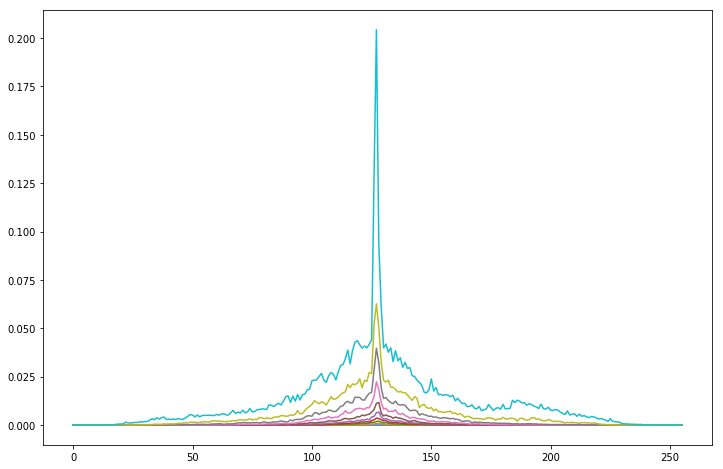

In [112]:
a = plot_percentile(boxplot[0],10)

接下来分析多条序列的情况！
多条序列：128个128个的取，避免重复
每个序列最终取出中位数   256个

In [19]:
multi_mut_maps = np.ndarray([100,384, 128])
with h5py.File('mutation/mutation_maps_100_no_overlap') as f:  
    for i in range(10):
        multi_mut_maps[10*i:10*(i+1)] = f['maps'+str(i)][:]

In [43]:
multi_mut_maps = np.abs(multi_mut_maps)

In [42]:
with h5py.File('mutation/mutation_maps_100_no_overlap_all') as f:
    multi_mut_maps = f['maps_all'][:]

In [43]:
multi_mut_maps.shape

(100, 384, 128)

In [20]:
muti_box_maps = generate_mutiple_boxplot(multi_mut_maps,100)
#output 100*384*256

In [11]:
def calculate_multi_percentile(box_maps,numbers,percentile):
    '''
        input multi box maps 100*384*256
        each maps calculate a 256 length percentile vector
        concatenate vectors together
        output percent array numbers*256
    '''
    percent_array = np.ndarray([numbers,256])
    for i in range(numbers):
        percent_array[i] = np.percentile(box_maps[i],50,axis = 0)
    return percent_array

In [12]:
percentile_array = calculate_multi_percentile(muti_box_maps,100,50)
#100*256

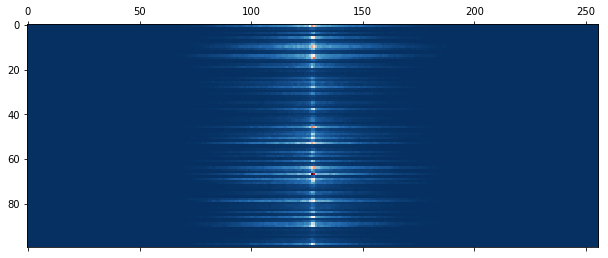

In [13]:
matshow(percentile_array,cmap = cm.RdBu_r)

[(0, 0.1)]

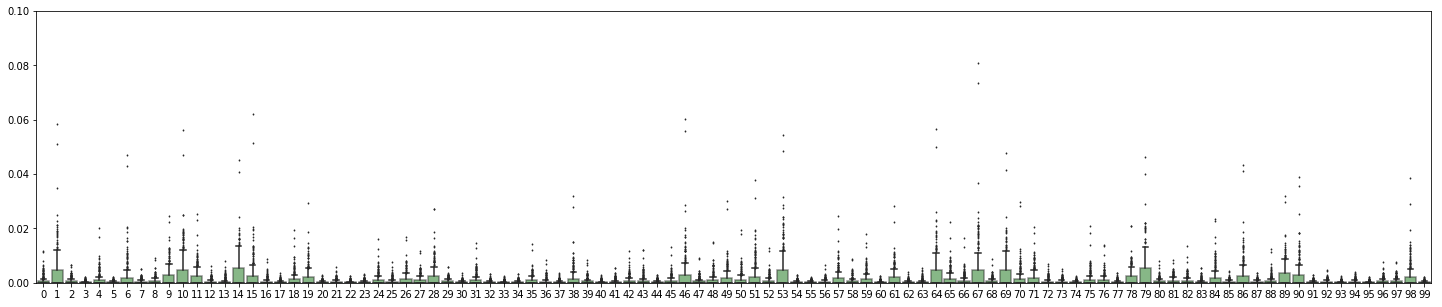

In [14]:
fig, ax = subplots(figsize=(25, 5))
sns.boxplot(data = pd.DataFrame(data=percentile_array.T), ax=ax,boxprops=dict(alpha=.5),color='g',fliersize= 1 )
ax.set(ylim=(0, .1))

和一条序列不太一样？
算过一次中位数了，单个序列的离群就被消除了

fig, ax = subplots(100,1,figsize=(60,600))
for i in range(100):
    sns.boxplot(data = pd.DataFrame(data=muti_box_maps[i]), ax=ax[i],boxprops=dict(alpha=.5),color='g')
fig.savefig('mutation/boxplot/boxplot_100.png')

(array([ 197.,   29.,   15.,   11.,    1.,    1.,    0.,    0.,    1.,    1.]),
 array([ 0.        ,  0.00585166,  0.01170333,  0.01755499,  0.02340665,
         0.02925831,  0.03510998,  0.04096164,  0.0468133 ,  0.05266496,
         0.05851663]),
 <a list of 10 Patch objects>)

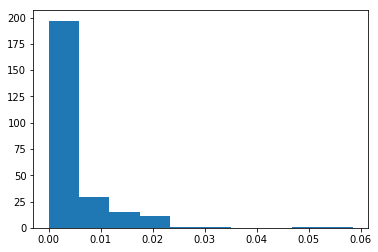

In [96]:
hist(np.percentile(muti_box_maps[1],50,axis= 0))

fig, ax = subplots(20,5,figsize=(40,240))
for i in range(20):
    for j in range(5):
        ax[i,j].matshow(muti_box_maps[5*i+j],cmap=cm.RdBu_r)
fig.savefig('mutation/100_different_seq/mutate_align_100.png')

mutcubemaps = multi_cube_map(multi_mut_maps,100)

In [50]:
with h5py.File('mutation/mutcubemaps_100') as f:
    mutcubemaps = f['cube'][:]

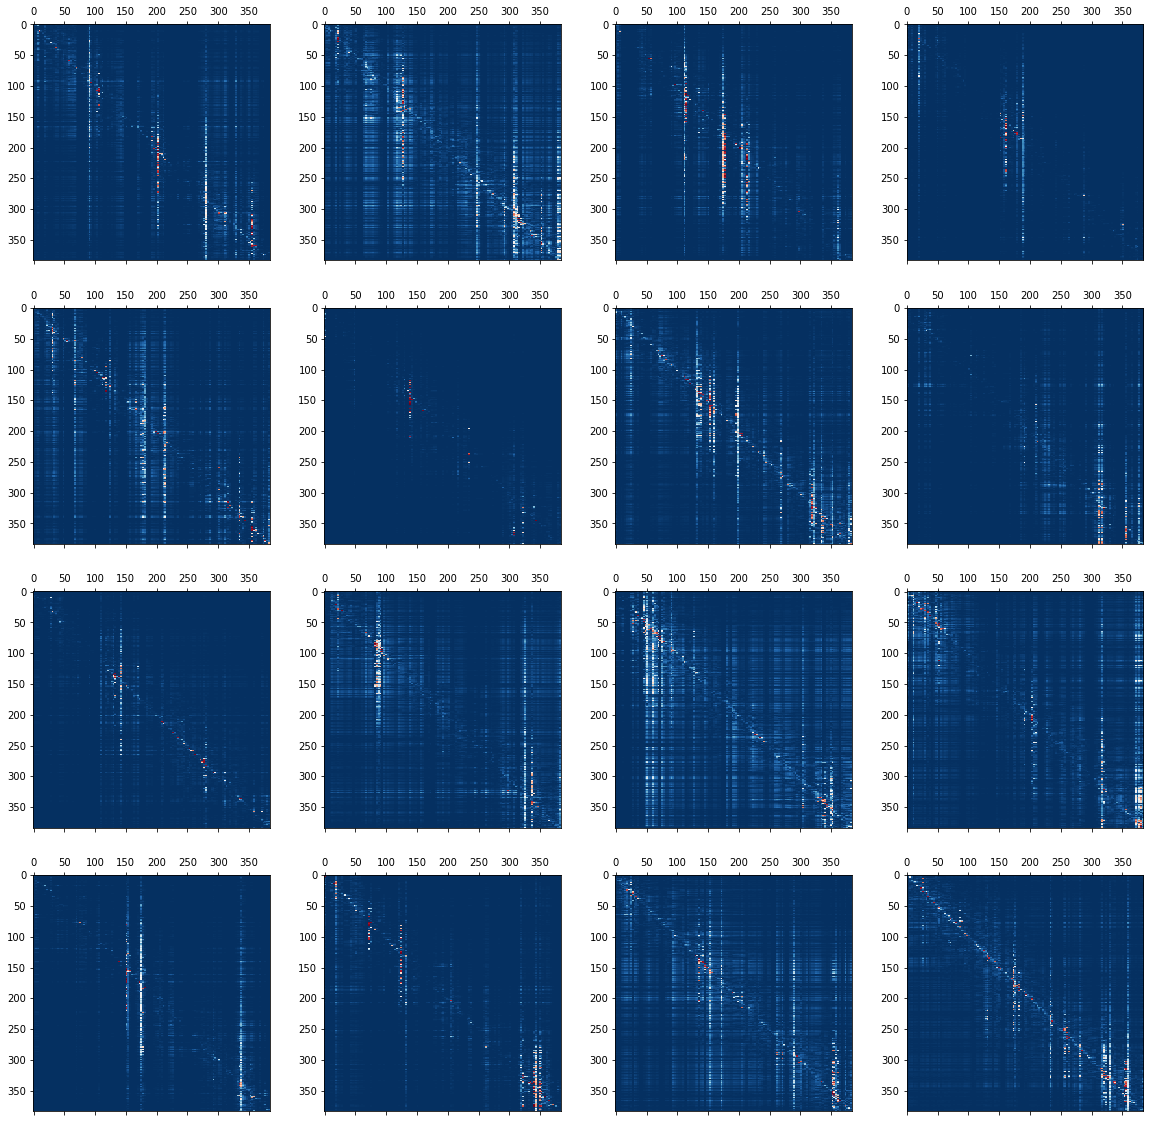

In [64]:
fig, ax = subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].matshow(mutcubemaps[4*i+j],cmap=cm.RdBu_r)
        a = np.where(np.isnan(icshape_label[4*i+j]) == 0)[0]*3
        b = np.repeat(370,a.shape[0])
        #ax[i,j].scatter(a,b,marker='*',c = 'r',s = 80)

In [ ]:
#找对应的序列的真实icshape

In [54]:
with h5py.File('data/new/Spitale_2015_invivo_CDS_0.1') as f:
    icshape_label = np.ndarray([100,128])
    for i in range(100):
        icshape_label[i] = f['y_train'][i*128]

In [57]:
np.where(np.isnan(icshape_label[0]) == 0)

(array([ 25,  30,  49,  63,  67,  71,  76,  87,  93, 109, 118, 125, 127]),)

fig, ax = subplots(25,4,figsize=(40,240))
for i in range(25):
    for j in range(4):
        ax[i,j].matshow(mutcubemaps[4*i+j],cmap=cm.RdBu_r)
fig.savefig('mutation/100_different_seq/mutate_and_map_100.png')

上面的竖线很奇怪
接下来试着看一下model最后一层全卷积层的输出！（看之前的代码怎么写的）
就是只看序列变化后二维图的变化

In [30]:
seqs = prepare_data(100)

In [32]:
seqs[0].shape

(128, 4)

In [33]:
def generate_images(seq):
    '''seq shape: 128*4
    将一条序列每个位点突变
    return 384*128*4
    '''
    length = 128
    #需要生成的 1的位置
    mutated = np.ndarray([length*3,length,4]).astype('int')
    for j in range(length):
        position = np.setdiff1d(np.array([0,1,2,3]),np.where(seq[j]==1)[0][0])
        for i in range(3):
            a = np.zeros(4).astype('int')
            array = np.copy(seq)
            a[position[i]] = 1
            array[j] = a
            mutated[j*3+i] = array
    images_mutated = np.ndarray([length*3,length,length,16]).astype('int')
    for i in range(length*3):
        images_mutated[i] = convert_to_image(mutated[i])
    images_origin = convert_to_image(seq)
    return images_mutated,images_origin

In [35]:
img_mut,img_ori = generate_images(seqs[0])

In [37]:
img_mut.shape

(384, 128, 128, 16)

In [ ]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function
# Testing
layer_outs = functor([images_test[:50], 1.])
#imshow 查看输出  94  91
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        ax[j,i].imshow(layer_outs[94][i*4+j,:,:,0],cmap=cm.RdBu_r)

In [ ]:
def generate_mutation_map(seq):
    '''seq shape: 128*4
    将一条序列每个位点突变
    return 384*128*4
    '''
    length = 128
    #需要生成的 1的位置
    mutated = np.ndarray([length*3,length,4]).astype('int')
    for j in range(length):
        position = np.setdiff1d(np.array([0,1,2,3]),np.where(seq[j]==1)[0][0])
        for i in range(3):
            a = np.zeros(4).astype('int')
            array = np.copy(seq)
            a[position[i]] = 1
            array[j] = a
            mutated[j*3+i] = array
    images_mutated = np.ndarray([length*3,length,length,16]).astype('int')
    for i in range(length*3):
        images_mutated[i] = convert_to_image(mutated[i])
    images_origin = convert_to_image(seq)
    
    
   

    model = Model()
    predict_origin = model.predict(images_origin.reshape(1,128,128,16))[0][:128]
    predict_mutated = model.predict(images_mutated)[:,:128]
    mutation_map = np.ndarray([128*3,128])
    for i in range(128*3):
        mutation_map[i] =  predict_origin - predict_mutated[i]
    return mutation_map